## Cluster Full Dataset

### Train ClusterClassifier on Subset

In [ ]:
from datasets import load_dataset

ds = load_dataset('openpecha/cleaned_MT_v1.0.3', split='train').select(range(500_000))['Target']

In [ ]:
from easy_text_clustering.clusterer import ClusterClassifier

cc = ClusterClassifier(embed_device='cuda', summary_create=False)

cc.fit(ds, clustering_args={'cluster_selection_method':'leaf','min_cluster_size':150, 'cluster_selection_epsilon': .15})

cc.save('500k-sample-cc')

cc.show()

In [ ]:
cc.cluster_summaries = cc.summarize(cc.texts, cc.cluster_labels)

In [ ]:
cc.fit(ds, clustering_args={'cluster_selection_method':'leaf','min_cluster_size':200, 'cluster_selection_epsilon': 0.1})
cc.show()

In [ ]:
from easy_text_clustering.clusterer import ClusterClassifier

cc = ClusterClassifier(embed_device='cuda')

cc.load('500k-sample-cc')

### Inference on Full Dataset

In [ ]:
from datasets import load_dataset

texts = load_dataset('openpecha/cleaned_MT_v1.0.3', split='train')['Target']

labels, embeddings = cc.infer(texts)

### Create New ClusterClassifier For Full Set

In [ ]:
new_cc = ClusterClassifier()

new_cc.texts = texts
new_cc.embeddings = embeddings # from inference above
new_cc.projections, new_cc.mapper = new_cc.project(embeddings, 'umap', {})
new_cc.cluster_labels = labels # from inference above
new_cc.store_cluster_info(new_cc.cluster_labels)
new_cc.cluster_summaries = new_cc.summarize(new_cc.texts, new_cc.cluster_labels)

In [ ]:
new_cc.save('full-inferred-cc')

In [ ]:
new_cc.show()

### Inspect Clusters

In [ ]:
from easy_text_clustering.clusterer import ClusterClassifier
new_cc = ClusterClassifier()
new_cc.load('full-inferred-cc')

In [ ]:
new_cc.cluster_summaries

### Separate Out Non-Buddhist Material

In [ ]:
non_buddhist_labels = [1,2,3,5,6,7,9,11,12,16,18,19,20,28,29,31]
non_buddhist_idx = []

for i in non_buddhist_labels:
    non_buddhist_idx.extend(new_cc.label2docs[i])

In [ ]:
buddhist_idx = list(set(range(len(new_cc.texts))) - set(non_buddhist_idx))

In [ ]:
idx_dict = {'Buddhist':buddhist_idx, 'Non-Buddhist': non_buddhist_idx}

In [ ]:
import pickle

with open('buddhist-or-no-idx-dict.pkl', 'wb') as handle:
    pickle.dump(idx_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Cluster Non-Buddhist Material

In [ ]:
import pickle

with open('buddhist-or-no-idx-dict.pkl', 'rb') as handle:
    idx_dict = pickle.load(handle)

In [ ]:
from datasets import load_dataset

ds = load_dataset('openpecha/cleaned_MT_v1.0.3', split='train')['Target']

nb_dict = [{'orig_idx':_, 'text':ds[_]} for _ in idx_dict['Non-Buddhist']]

nb_dict[0]

In [ ]:
nb_texts = [elt['text'] for elt in nb_dict]
nb_texts[0]

In [ ]:
from easy_text_clustering.clusterer import ClusterClassifier
nbcc = ClusterClassifier(embed_device='cuda', summary_create=False)
nbcc.optimize_fit(nb_texts)

In [ ]:
nbcc.cluster_summaries = nbcc.summarize(nbcc.texts, nbcc.cluster_labels)

In [ ]:
nbcc.save('non-buddhist-cc')

### Inspect Clustering

In [ ]:
nbcc.show()

In [ ]:
nbcc.cluster_summaries

In [ ]:
[nbcc.texts[_] for _ in nbcc.label2docs[18]]

### Manually Group Clusters and Save as Dictionary

Medicine & Biology 1, 7
Science 1,7,12,13
History & Politics 0, 3, 5, 6,9,10
Law 6
Fiction 2,4, 8,14,17, 18
Business 11
Language & Culture 9,15
Journalism 16

In [ ]:
label_dict = {'Medicine & Biology': [1,7], 
              'Science': [1,7,12,13], 
              'History & Politics': [0,3,5,6,9,10], 
              'Law': [6],
              'Fiction': [2,4,8,14,17,18],
              'Business':[11],
              'Language & Culture': [9,15],
              'Journalism': [16]}

In [ ]:
label_idx_dict = {
    label: [
        nb_dict[idx]['orig_idx'] 
        for elt in label_dict[label] 
        for idx in nbcc.label2docs[elt]
    ]
    for label in label_dict
}


In [ ]:
label_idx_dict.keys()

In [ ]:
import pickle

with open('non-buddhist-labels-idx-dict.pkl', 'wb') as handle:
    pickle.dump(label_idx_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Cluster Buddhist Material

In [ ]:
from datasets import load_dataset
import pickle

with open('buddhist-or-no-idx-dict.pkl', 'rb') as handle:
    idx_dict = pickle.load(handle)

ds = load_dataset('openpecha/cleaned_MT_v1.0.3', split='train')['Target']

b_dict = [{'orig_idx':_, 'text':ds[_]} for _ in idx_dict['Buddhist']]

print(b_dict[0])

b_texts = [elt['text'] for elt in b_dict]
print(b_texts[0])

### Remove Additional Non-Buddhist Material

#### Fit Classifier on Randomized Subset

In [ ]:
import random
random_subset = random.sample(b_texts, 500_000)
random_subset[0]

In [ ]:
from easy_text_clustering.clusterer import ClusterClassifier
bcc = ClusterClassifier(embed_device='cuda', summary_create=False)
bcc.fit(random_subset, clustering_args={'cluster_selection_method':'leaf','min_cluster_size':150, 'cluster_selection_epsilon':0.08})
bcc.save('buddhist-500k-sample-cc')
bcc.show()

#### Inference on Full Buddhist Dataset

In [ ]:
labels, embeddings = bcc.infer(b_texts)

In [ ]:
new_cc = ClusterClassifier()

new_cc.texts = b_texts
new_cc.embeddings = embeddings # from inference above
new_cc.projections, new_cc.mapper = new_cc.project(embeddings, 'umap', {})
new_cc.cluster_labels = labels # from inference above
new_cc.store_cluster_info(new_cc.cluster_labels)
new_cc.cluster_summaries = {}
new_cc.save('buddhist-inferred-cc')

In [ ]:
new_cc.cluster_summaries = new_cc.summarize(new_cc.texts, new_cc.cluster_labels)
new_cc.save('buddhist-inferred-cc')
new_cc.show()

#### Inspect Clusters

In [ ]:
new_cc.cluster_summaries

In [ ]:
[new_cc.texts[_] for _ in new_cc.label2docs[33]]

#### Extract Additional Non-Buddhist Material

In [ ]:
med_bio = []
science = [15,23]
hist_pol = [1,15,24,26]
law = []
fiction = [6,13]
business = []
lang_cult = []
journalism = []
astronomy = []


#### Update Index Dictionaries

In [ ]:
import pickle

with open('non-buddhist-labels-idx-dict.pkl', 'rb') as handle:
    nb_idx_dict = pickle.load(handle)

def extend_label(label, new_idx_lists):

    print(len(nb_idx_dict[label]))

    new_idx = []

    for elt in new_idx_lists:
        new_idx.extend(new_cc.label2docs[elt])

    new_orig_idx = [b_dict[_]['orig_idx'] for _ in new_idx]

    nb_idx_dict[label].extend(new_orig_idx)

    print(len(nb_idx_dict[label]))

def update_idx():
    idx_dict = {}

    non_buddhist_idx = []

    for val in nb_idx_dict.values():
        non_buddhist_idx.extend(val)

    buddhist_idx = list(set(range(len(new_cc.texts))) - set(non_buddhist_idx))

    idx_dict['Buddhist'] = buddhist_idx
    idx_dict['Non-Buddhist'] = non_buddhist_idx

    with open('buddhist-or-no-idx-dict.pkl', 'wb') as handle:
        pickle.dump(idx_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
extend_label('Medicine & Biology', med_bio)
extend_label('Science', science)
extend_label('History & Politics', hist_pol)
extend_label('Law', law)
extend_label('Fiction', fiction)
extend_label('Business', business)
extend_label('Language & Culture', lang_cult)
extend_label('Journalism', journalism)


with open('non-buddhist-labels-idx-dict.pkl', 'wb') as handle:
    pickle.dump(nb_idx_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

update_idx()

### Cluster Buddhist Material

In [ ]:
from datasets import load_dataset
import pickle

with open('buddhist-or-no-idx-dict.pkl', 'rb') as handle:
    idx_dict = pickle.load(handle)

ds = load_dataset('openpecha/cleaned_MT_v1.0.3', split='train')['Target']

b_dict = [{'orig_idx':_, 'text':ds[_]} for _ in idx_dict['Buddhist']]

print(b_dict[0])

b_texts = [elt['text'] for elt in b_dict]
print(b_texts[0])

#### Fit on Random Sample

In [ ]:
import random
random_subset = random.sample(b_texts, 500_000)
print(random_subset[0])

In [ ]:
from easy_text_clustering.clusterer import ClusterClassifier
bcc = ClusterClassifier(embed_device='cuda', summary_create=False)
bcc.fit(random_subset, clustering_args={'cluster_selection_method':'leaf','min_cluster_size':150, 'cluster_selection_epsilon':0.075})
bcc.save('2nd-buddhist-500k-sample-cc')
bcc.show()

#### Inference on Full Buddhist Material

In [ ]:
labels, embeddings = bcc.infer(b_texts)

In [ ]:
new_cc = ClusterClassifier()

new_cc.texts = b_texts
new_cc.embeddings = embeddings # from inference above
new_cc.projections, new_cc.mapper = new_cc.project(embeddings, 'umap', {})
new_cc.cluster_labels = labels # from inference above
new_cc.store_cluster_info(new_cc.cluster_labels)

In [ ]:
new_cc.cluster_summaries = {}
new_cc.save('buddhist-inferred-cc')

In [ ]:
new_cc.cluster_summaries = new_cc.summarize(new_cc.texts, new_cc.cluster_labels)

In [ ]:
new_cc.save('buddhist-inferred-cc')

In [ ]:
new_cc.show()

#### Extract Meaningful Clusters

In [ ]:
new_cc.cluster_summaries

In [ ]:
new_cc.label2docs[51]

In [ ]:
b_idx_dict = {}

In [ ]:
#'Intrinsic Existence, Conventional Existence'
existence = [0]
#'Time, Causality, Perception'
tcp = [3]
#'Aggregates, Self, Conventional Designation'
agg = [4]
#'Kayas'
kayas = [5,6,7]
#'Milarepa, Realization, Biography'
mil = [9]
#'Samaya, Conduct'
sam = [11]
#'Emptiness'
empt = [12,17,18,39]
#'Education, Teaching, Communication'
edu = [15]
#'Conceptual Positions, Philosophical Schools, Logical Reasoning'
logic = [16]
#'Natural State'
nat_state = [19]
# 'Great Mother, Samsara-Nirvana, Non-duality'
non_dual = [21]
# 'Tantra'
tantra = [24,47,48]
# 'Karma, Consequences'
karma = [32]
# 'Cause and effect, dependent origination, conditionality'
condition = [44]

In [ ]:
extend_buddhist_label('Intrinsic Existence, Conventional Existence',existence)
extend_buddhist_label('Time, Causality, Perception',tcp)
extend_buddhist_label('Aggregates, Self, Conventional Designation',agg)
extend_buddhist_label('Kayas',kayas)
extend_buddhist_label('Milarepa, Realization, Biography',mil)
extend_buddhist_label('Samaya, Conduct',sam)
extend_buddhist_label('Emptiness',empt)
extend_buddhist_label('Education, Teaching',edu)
extend_buddhist_label('Conceptual Positions, Philosophical Schools, Logical Reasoning',logic)
extend_buddhist_label('Conceptual Positions, Logical Reasoning',logic)
extend_buddhist_label('Natural State',nat_state)
extend_buddhist_label('Samsara-Nirvana, Non-duality',non_dual)
extend_buddhist_label('Tantra',tantra)
extend_buddhist_label('Karma, Consequences',karma)
extend_buddhist_label('Cause and effect, dependent origination, conditionality',condition)

In [ ]:
with open('buddhist-labels-idx-dict.pkl', 'wb') as handle:
    pickle.dump(b_idx_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
non_buddhist_idx = []

for val in nb_idx_dict.values():
    non_buddhist_idx.extend(val)

buddhist_idx = list(set(range(len(new_cc.texts))) - set(non_buddhist_idx))

print(len(buddhist_idx))

In [ ]:
buddhist_cat_idx = []

for val in b_idx_dict.values():
    buddhist_cat_idx.extend(val)

uncat_idx = list(set(range(len(buddhist_idx))) - set(buddhist_cat_idx))

print(len(uncat_idx))

In [ ]:
with open('uncat-idx-list.pkl', 'wb') as handle:
    pickle.dump(uncat_idx, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
[new_cc.texts[_] for _ in new_cc.label2docs[51]]

In [ ]:
med_bio = [34]
science = [26,34]
hist_pol = [1,31,50,51]
law = []
fiction = []
business = [20]
lang_cult = []
journalism = []

In [ ]:
import pickle

with open('non-buddhist-labels-idx-dict.pkl', 'rb') as handle:
    nb_idx_dict = pickle.load(handle)

def extend_buddhist_label(label, new_idx_lists):

    #print(len(b_idx_dict[label]))

    #b_idx_dict[label] = []

    new_idx = []

    for elt in new_idx_lists:
        new_idx.extend(new_cc.label2docs[elt])

    new_orig_idx = [b_dict[_]['orig_idx'] for _ in new_idx]

    b_idx_dict[label].extend(new_orig_idx)

    print(len(b_idx_dict[label]))

def extend_nb_label(label, new_idx_lists):

    print(len(nb_idx_dict[label]))

    new_idx = []

    for elt in new_idx_lists:
        new_idx.extend(new_cc.label2docs[elt])

    new_orig_idx = [b_dict[_]['orig_idx'] for _ in new_idx]

    nb_idx_dict[label].extend(new_orig_idx)

    print(len(nb_idx_dict[label]))

def update_idx():
    idx_dict = {}

    non_buddhist_idx = []

    for val in nb_idx_dict.values():
        non_buddhist_idx.extend(val)

    buddhist_idx = list(set(range(len(new_cc.texts))) - set(non_buddhist_idx))

    idx_dict['Buddhist'] = buddhist_idx
    idx_dict['Non-Buddhist'] = non_buddhist_idx

    with open('buddhist-or-no-idx-dict.pkl', 'wb') as handle:
        pickle.dump(idx_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
extend_nb_label('Medicine & Biology', med_bio)
extend_nb_label('Science', science)
extend_nb_label('History & Politics', hist_pol)
extend_nb_label('Law', law)
extend_nb_label('Fiction', fiction)
extend_nb_label('Business', business)
extend_nb_label('Language & Culture', lang_cult)
extend_nb_label('Journalism', journalism)


with open('non-buddhist-labels-idx-dict.pkl', 'wb') as handle:
    pickle.dump(nb_idx_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

update_idx()

#### Continue Extraction

In [3]:
from datasets import load_dataset
import pickle

with open('uncat-idx-list.pkl', 'rb') as handle:
    uncat_list = pickle.load(handle)

ds = load_dataset('openpecha/cleaned_MT_v1.0.3', split='train')['Target']

idx_dict = [{'orig_idx':_, 'text':ds[_]} for _ in uncat_list]

print(idx_dict[0])

uncat_texts = [elt['text'] for elt in idx_dict]
print(uncat_texts[0])

{'orig_idx': 6, 'text': 'If you analyze and investigate what can be shown through reasonings—that has no color or shape; that, like space, it does not exist; that it is neither singular nor a plurality; that it does not arise; or that it is naturally luminous—you will realize it does not exist.'}
If you analyze and investigate what can be shown through reasonings—that has no color or shape; that, like space, it does not exist; that it is neither singular nor a plurality; that it does not arise; or that it is naturally luminous—you will realize it does not exist.


In [4]:
len(uncat_texts)

392325

In [3]:
import random
random_subset = random.sample(uncat_texts, 100_000)
random_subset[0]

'A few agents of the Thought Police moved always among them, spreading false rumours'

INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2
/home/j/Documents/MLotsawa/.venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
INFO:root:Embedding texts...


Batches:   0%|          | 0/1563 [00:00<?, ?it/s]

INFO:root:Building FAISS index...
INFO:root:Projecting with umap...
INFO:root:Clustering...


Using HDBSCAN params={'cluster_selection_method': 'leaf', 'min_cluster_size': 150, 'cluster_selection_epsilon': 0.2}


AttributeError: 'NoneType' object has no attribute 'keys'

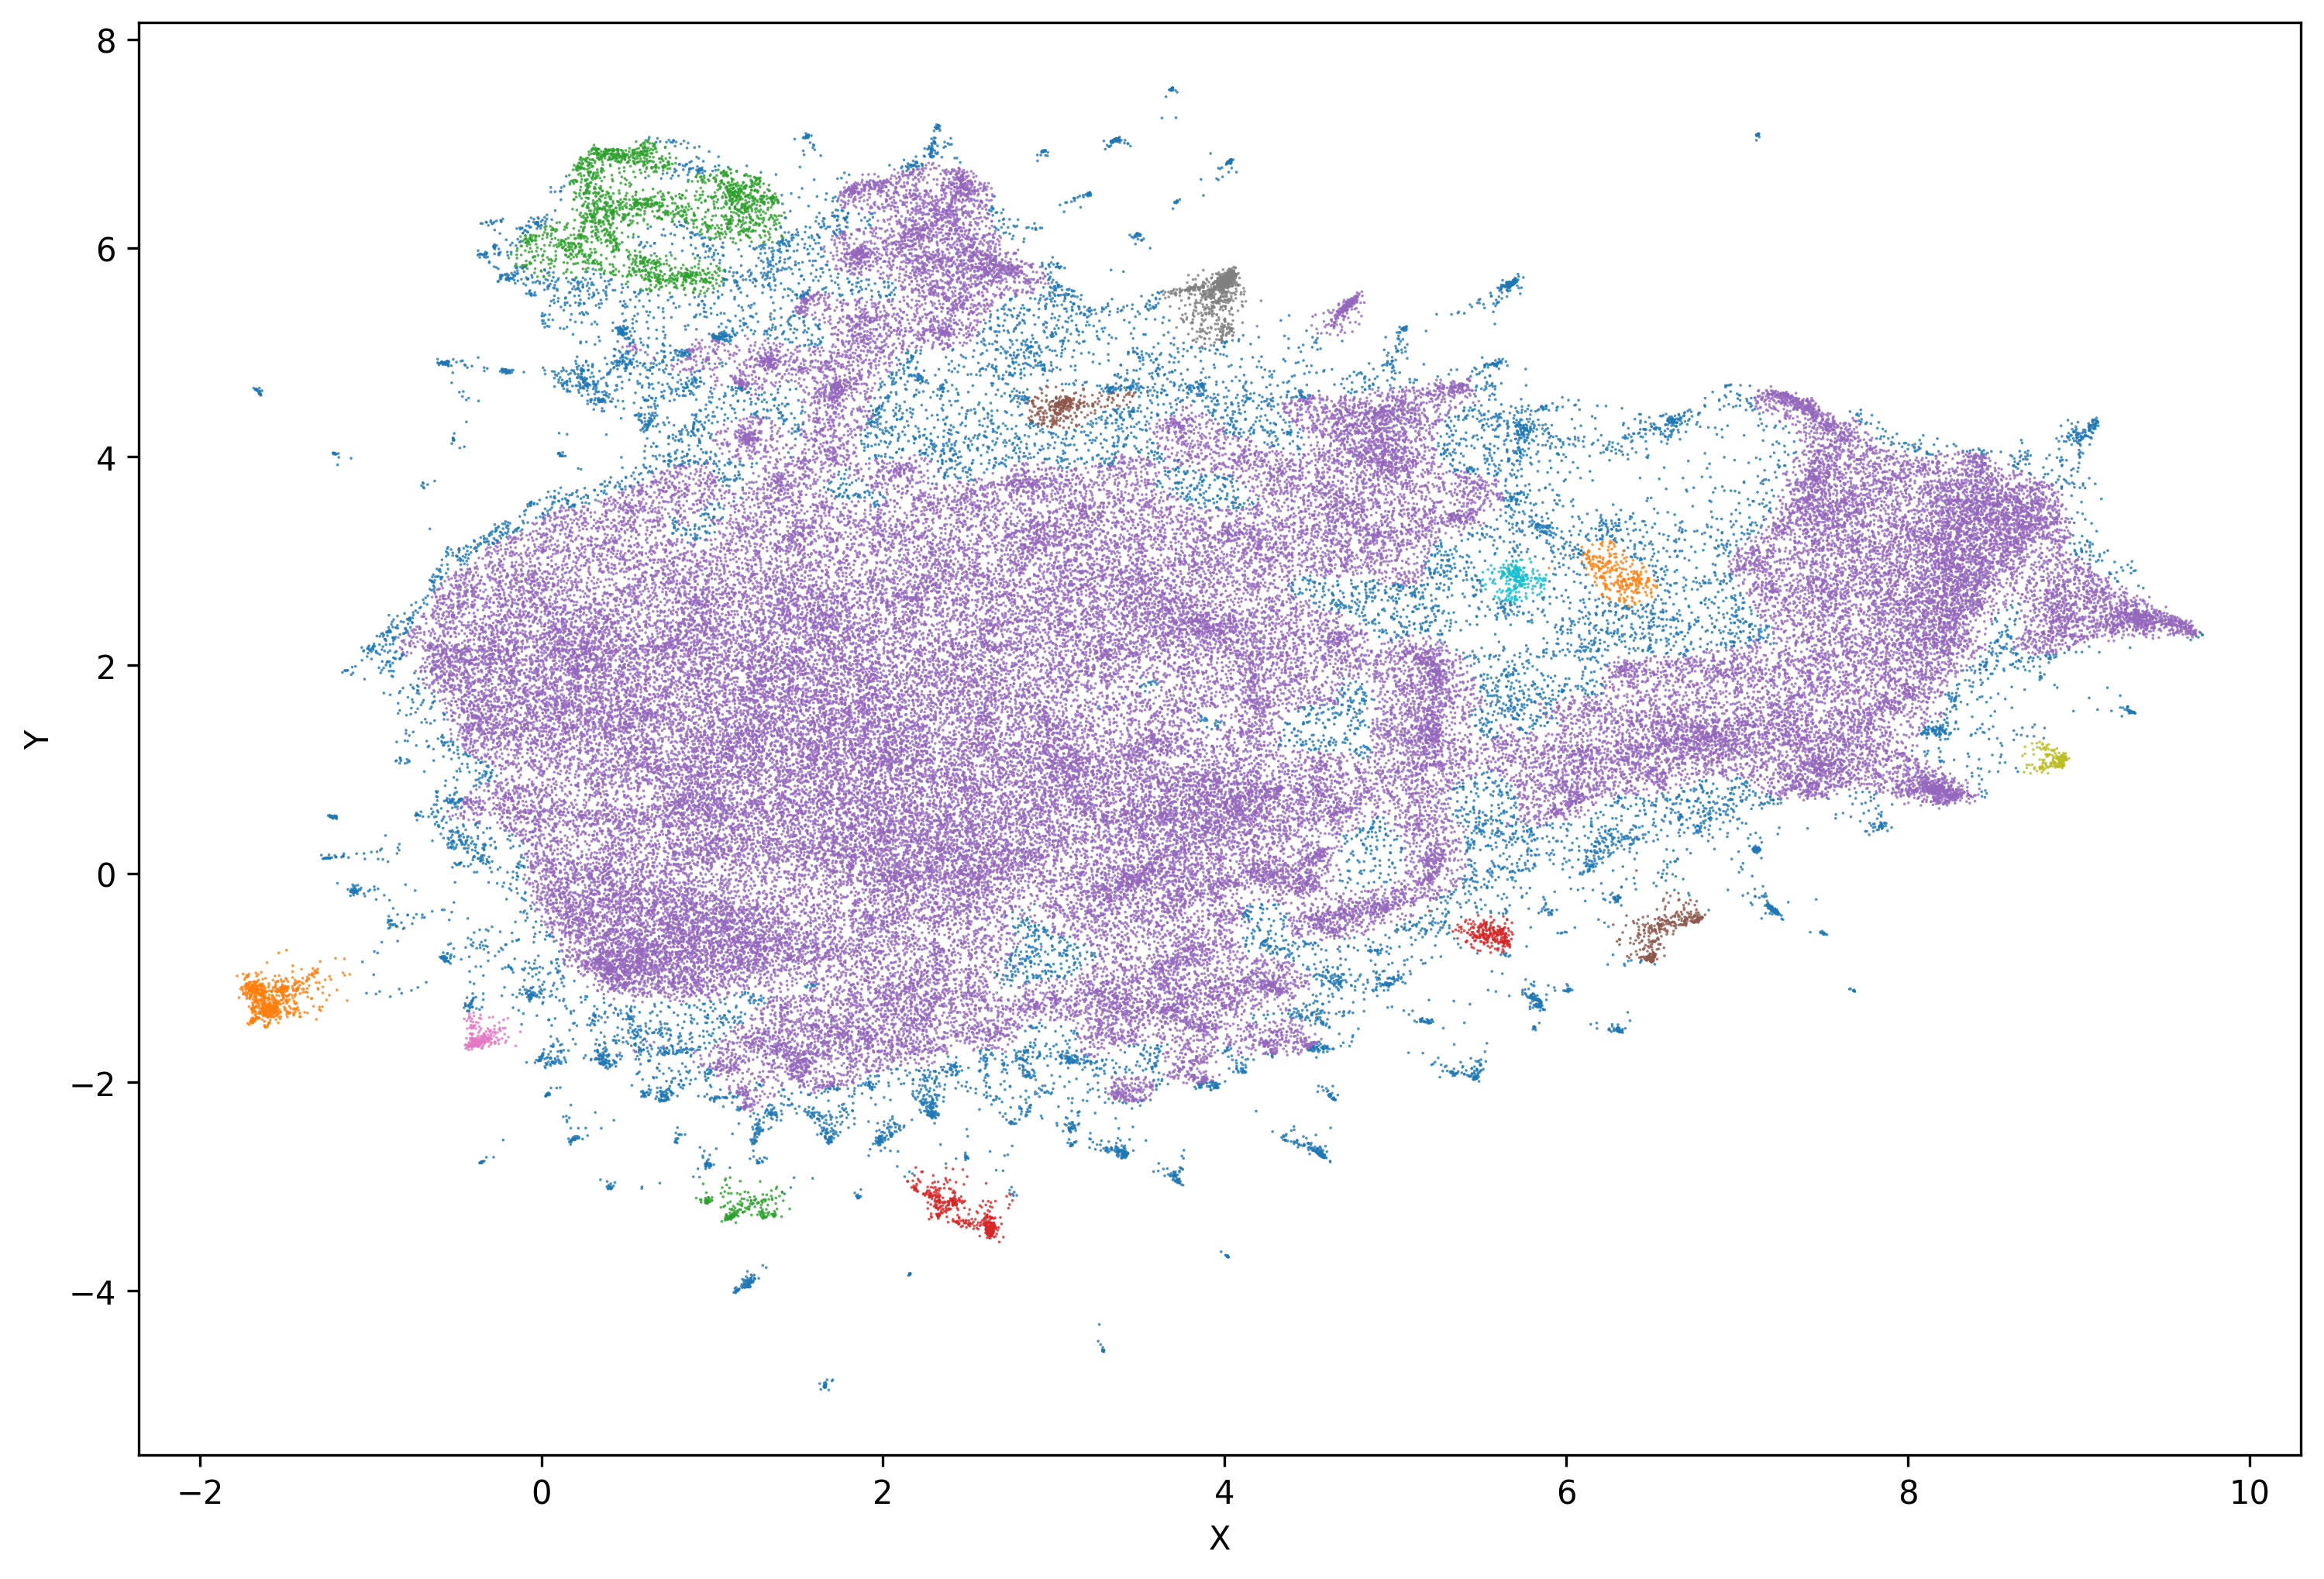

In [4]:
from easy_text_clustering.clusterer import ClusterClassifier
bcc = ClusterClassifier(embed_device='cuda', summary_create=False)
bcc.fit(random_subset, clustering_args={'cluster_selection_method':'leaf','min_cluster_size':150, 'cluster_selection_epsilon':0.2})
bcc.save('7th-100k-sample-cc')
bcc.show()

INFO:root:Using precomputed embeddings...
INFO:root:Building FAISS index...
INFO:root:Using precomputed projections...
INFO:root:Clustering...


Using HDBSCAN params={'cluster_selection_method': 'leaf', 'min_cluster_size': 150, 'cluster_selection_epsilon': 0.175}


AttributeError: 'NoneType' object has no attribute 'keys'

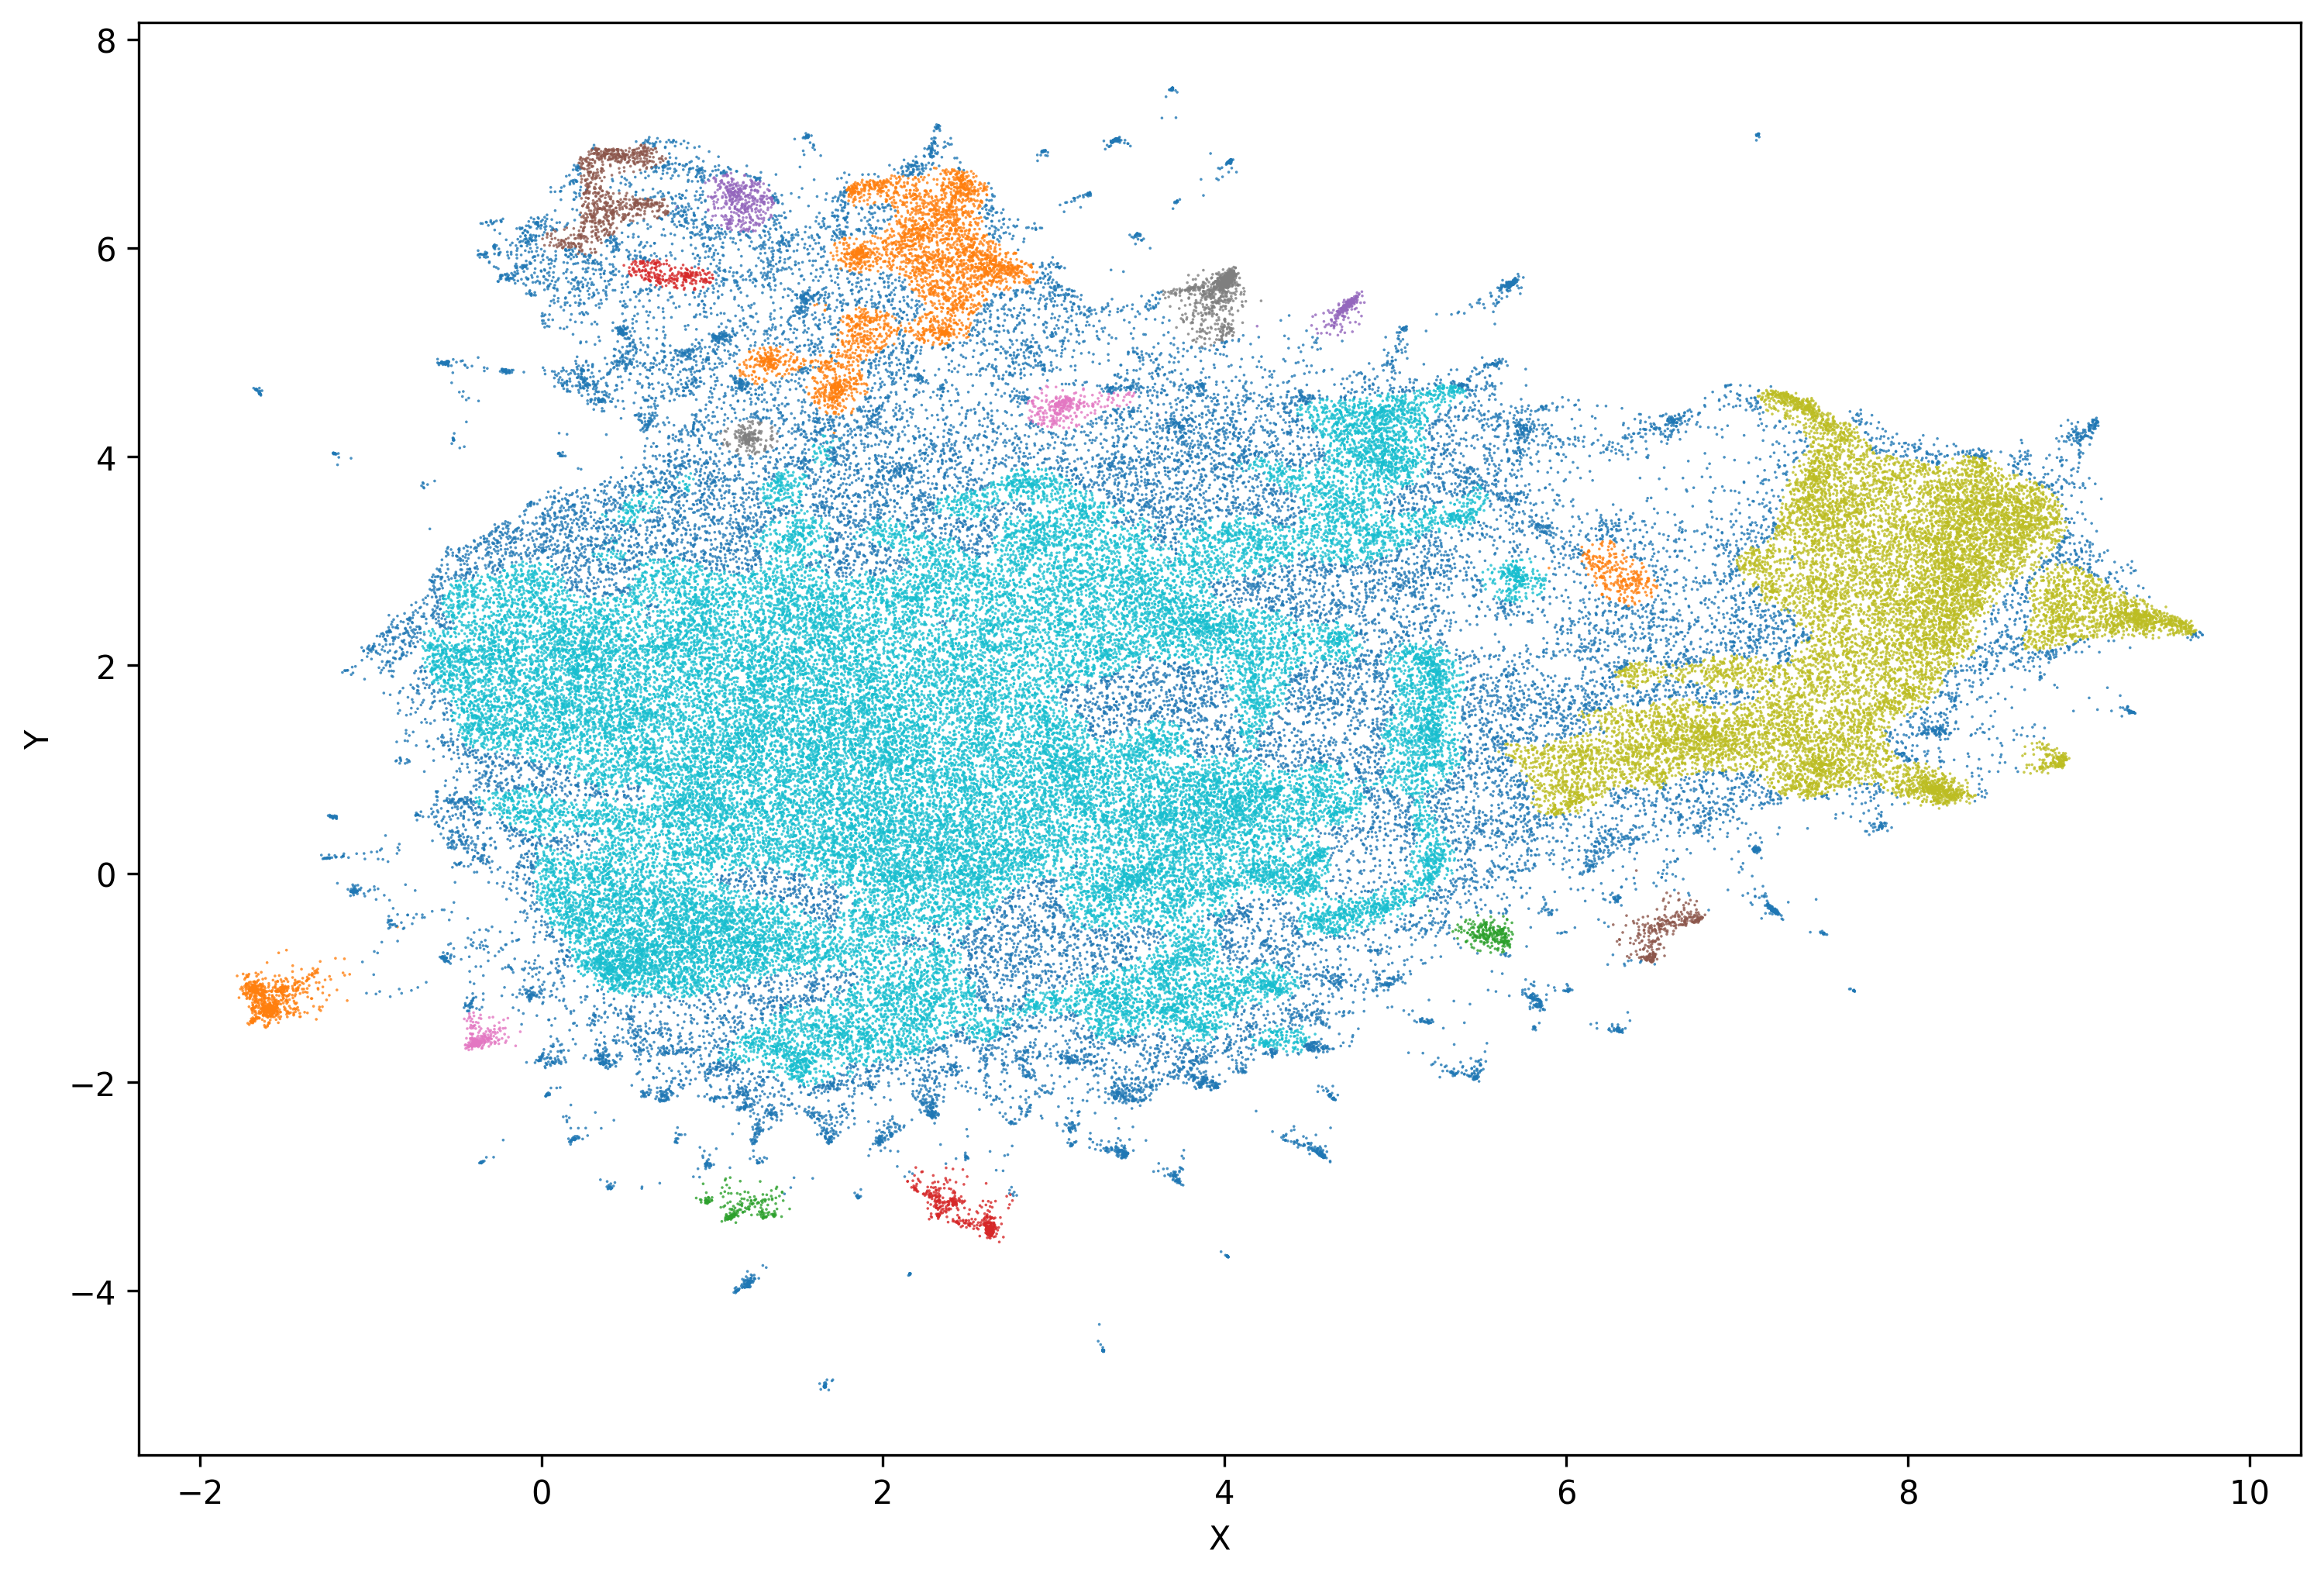

In [6]:
bcc.fit(clustering_args={'cluster_selection_method':'leaf','min_cluster_size':150, 'cluster_selection_epsilon':0.175})
bcc.save('7th-100k-sample-cc')
bcc.show()

In [6]:
from easy_text_clustering.clusterer import ClusterClassifier

bcc = ClusterClassifier(embed_device='cuda')
bcc.load('7th-100k-sample-cc')

INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2
/home/j/Documents/MLotsawa/.venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:
labels, embeddings = bcc.infer(uncat_texts)

Batches:   0%|          | 0/6131 [00:00<?, ?it/s]

100%|██████████| 392325/392325 [00:00<00:00, 442360.53it/s]


In [ ]:
new_cc = ClusterClassifier()

new_cc.texts = uncat_texts
new_cc.embeddings = embeddings # from inference above
new_cc.projections, new_cc.mapper = new_cc.project(embeddings, 'umap', {})
new_cc.cluster_labels = labels # from inference above
new_cc.store_cluster_info(new_cc.cluster_labels)
new_cc.cluster_summaries = {}
new_cc.save('7th-inferred-cc')
new_cc.show()

INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2
Projecting embeddings: 100%|██████████| 2/2 [00:45<00:00, 22.70s/it]


In [ ]:
new_cc.cluster_summaries = new_cc.summarize(new_cc.texts, new_cc.cluster_labels)
new_cc.save('7th-inferred-cc')
new_cc.show()

In [ ]:
# util funcs

import pickle

with open('non-buddhist-labels-idx-dict.pkl', 'rb') as handle:
    nb_idx_dict = pickle.load(handle)

with open('buddhist-labels-idx-dict.pkl', 'rb') as handle:
    b_idx_dict = pickle.load(handle)

def extend_buddhist_label(label, new_idx_lists):

    if label not in b_idx_dict:
        b_idx_dict[label] = []

    new_idx = []

    for elt in new_idx_lists:
        new_idx.extend(new_cc.label2docs[elt])

    new_orig_idx = [idx_dict[_]['orig_idx'] for _ in new_idx]

    b_idx_dict[label].extend(new_orig_idx)

    print(len(b_idx_dict[label]))

    with open('buddhist-labels-idx-dict.pkl', 'wb') as handle:
        pickle.dump(b_idx_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

def extend_nb_label(label, new_idx_lists):

    if label not in nb_idx_dict:
        nb_idx_dict[label] = []

    print(len(nb_idx_dict[label]))

    new_idx = []

    for elt in new_idx_lists:
        new_idx.extend(new_cc.label2docs[elt])

    new_orig_idx = [idx_dict[_]['orig_idx'] for _ in new_idx]

    nb_idx_dict[label].extend(new_orig_idx)

    print(len(nb_idx_dict[label]))

    with open('non-buddhist-labels-idx-dict.pkl', 'wb') as handle:
        pickle.dump(nb_idx_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

def update_idx():
    idx_dict = {}

    non_buddhist_idx = []

    for val in nb_idx_dict.values():
        non_buddhist_idx.extend(val)

    buddhist_idx = list(set(range(len(ds))) - set(non_buddhist_idx))

    idx_dict['Buddhist'] = buddhist_idx
    idx_dict['Non-Buddhist'] = non_buddhist_idx

    buddhist_cat_idx = []

    for val in b_idx_dict.values():
        buddhist_cat_idx.extend(val)

    uncat_idx = list(set(range(len(buddhist_idx))) - set(buddhist_cat_idx))
    
    with open('buddhist-or-no-idx-dict.pkl', 'wb') as handle:
        pickle.dump(idx_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open('uncat-idx-list.pkl', 'wb') as handle:
        pickle.dump(uncat_idx, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
new_cc.cluster_summaries

In [ ]:
[new_cc.texts[_] for _ in new_cc.label2docs[18]]

In [ ]:
nb_idx_dict.keys()

In [ ]:
extend_nb_label('Fiction', [1,2,3,4,13])
extend_nb_label('History & Politics', [11,12,18])
extend_nb_label('Business', [1])
extend_nb_label('Science & Medicine', [6,10])
extend_nb_label('Language & Culture', [7])

In [ ]:
b_idx_dict.keys()

In [ ]:
extend_buddhist_label('Dharma', [14])
extend_buddhist_label('Mind', [])
extend_buddhist_label('Bodhisattva, Conduct, Wisdom', [])
extend_buddhist_label('Time, Causality, Perception', [9])
extend_buddhist_label('Tantra', [16,17,19])
extend_buddhist_label('Monastery', [])
extend_buddhist_label('Sakya', [])
extend_buddhist_label('Samsara-Nirvana', [])
extend_buddhist_label('Middle Way', [])
extend_buddhist_label('Prophecies, Rituals', [])
extend_buddhist_label('Cause and effect, dependent origination, conditionality', [])
extend_buddhist_label('Faith, Refuge', [])
extend_buddhist_label('Conceptual Positions, Logical Reasoning', [8])
extend_buddhist_label('Emptiness', [])
extend_buddhist_label('Enlightenment', [])
extend_buddhist_label('Meditation', [])
extend_buddhist_label('Mantras', [])
extend_buddhist_label('Milarepa, Realization, Biography', [])
extend_buddhist_label('Intrinsic Existence, Conventional Existence', [])
extend_buddhist_label('Dzogchen', [])
extend_buddhist_label('Mahamudra', [])
extend_buddhist_label('Lama', [])
extend_buddhist_label('Dreams', [])
extend_buddhist_label('Astrology', [5])

In [ ]:
update_idx()

## Validate Results

### Open Data and Index Dictionaries

In [ ]:
import pickle
from datasets import load_dataset

ds = load_dataset('openpecha/cleaned_MT_v1.0.3', split='train')['Target']

with open('non-buddhist-labels-idx-dict.pkl', 'rb') as handle:
    nb_idx_dict = pickle.load(handle)

with open('buddhist-labels-idx-dict.pkl', 'rb') as handle:
    b_idx_dict = pickle.load(handle)

### Create ClusterClassifier for Validation

In [ ]:
from easy_text_clustering.clusterer import ClusterClassifier

val_cc = ClusterClassifier(embed_device='cuda')
val_cc.texts = ds
val_cc.embeddings = val_cc.embed(val_cc.texts)
val_cc.projections, val_cc.mapper = val_cc.project(val_cc.embeddings, 'umap', {})

In [ ]:
val_cc.cluster_summaries = {}

In [ ]:
val_cc.save('wip-final-cc')

### Convert Label Index Dictionaries to Cluster Label List

In [ ]:
# deduplicate

for key, val in nb_idx_dict.items():
    nb_idx_dict[key] = list(set(val))

for key, val in b_idx_dict.items():
    b_idx_dict[key] = list(set(val))

In [ ]:
# fuse redundant categories

print(nb_idx_dict.keys())

nb_idx_dict['Science & Medicine'] = list(set(nb_idx_dict['Medicine & Biology'] + nb_idx_dict['Science']))

del nb_idx_dict['Medicine & Biology']
del nb_idx_dict['Science']

print(nb_idx_dict.keys())

In [ ]:
# delete empty entries

for key, val in b_idx_dict.items():
    if len(val) == 0:
        print(key)

In [ ]:
# Create the labels list and a mapping from label to its index
labels = list(b_idx_dict.keys()) + list(nb_idx_dict.keys())
label_to_index = {label: idx for idx, label in enumerate(labels)}

# Precompute a lookup dictionary for all indices with label indices
lookup = {}

for j, idx_list in b_idx_dict.items():
    for idx in idx_list:
        lookup[idx] = label_to_index[j]

for j, idx_list in nb_idx_dict.items():
    for idx in idx_list:
        lookup[idx] = label_to_index[j]

# Generate idx_labels based on the precomputed lookup
idx_labels = [lookup.get(i, -1) for i in range(len(val_cc.texts))]

In [ ]:
summaries = {}

for i in range(len(labels)):
    summaries[i] = labels[i]

In [ ]:
labels

In [ ]:
val_cc.cluster_labels = idx_labels
val_cc.store_cluster_info(val_cc.cluster_labels)
val_cc.cluster_summaries = summaries

In [ ]:
val_cc.cluster_summaries

In [ ]:
[val_cc.texts[_] for _ in val_cc.label2docs[31]]

### Inspect Categories

In [ ]:
val_cc.show()

### Generate Alternative Labels

In [ ]:
val_cc.summarize(val_cc.texts, val_cc.cluster_labels)

In [ ]:
val_cc.save('wip-final-cc')

## Add Tags to Dataset

In [1]:
import pickle
from datasets import load_dataset

ds = load_dataset('openpecha/cleaned_MT_v1.0.3', split='train')

with open('non-buddhist-labels-idx-dict.pkl', 'rb') as handle:
    nb_idx_dict = pickle.load(handle)

with open('buddhist-labels-idx-dict.pkl', 'rb') as handle:
    b_idx_dict = pickle.load(handle)

In [2]:
# Create a reverse mapping of row index to tag
nb_index_to_tag = {}
for tag, indices in nb_idx_dict.items():
    for index in indices:
        nb_index_to_tag[index] = tag

b_index_to_tag = {}
for tag, indices in b_idx_dict.items():
    for index in indices:
        b_index_to_tag[index] = tag

# Define a function to add the Tag column
def nb_add_tags(example, idx):
    return {'Tag': nb_index_to_tag.get(idx, '')}

def b_add_tags(example, idx):
    return {'Tag': b_index_to_tag.get(idx, '')}

# Use the `map` method with `with_indices=True`
tagged_ds = ds.map(nb_add_tags, with_indices=True)
tagged_ds = tagged_ds.map(b_add_tags, with_indices=True)

In [3]:
tagged_ds.push_to_hub('openpecha/tagged_cleaned_MT_v1.0.3')

Uploading the dataset shards:   0%|          | 0/3 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/477 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/477 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/477 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/openpecha/tagged_cleaned_MT_v1.0.3/commit/0d12861400af4d03e05f4e023c05e3c25dacc1ef', commit_message='Upload dataset', commit_description='', oid='0d12861400af4d03e05f4e023c05e3c25dacc1ef', pr_url=None, pr_revision=None, pr_num=None)

In [5]:
tagged_ds[1000]

{'Source': 'གལ་ཏེ་ང་ཚོའི་སེམས་དེ་ཞེད་སྣང་དང་། ཐེ་ཚོམ། ཞེ་སྡང་། སོགས་ཀྱིས་བསྐངས་ན་རང་སྣང་གི་སྐུལ་མས་དེ་དག་ནུས་པ་མཐུ་ཆེན་དུ་གྱུར་ནས་དོན་དངོས་སུ་ཞེད་སྣང་ཅན་སོགས་སུ་འགྱུར་བ་རེད།',
 'Target': 'If we feed our mind with thoughts of fear, doubt, and hate, the autosuggestions will activate and translate those things into reality.',
 'File_Name': 'TM0059',
 'Machine Aligned': True,
 '__index_level_0__': 1003,
 'Tag': 'Prophecies, Rituals'}

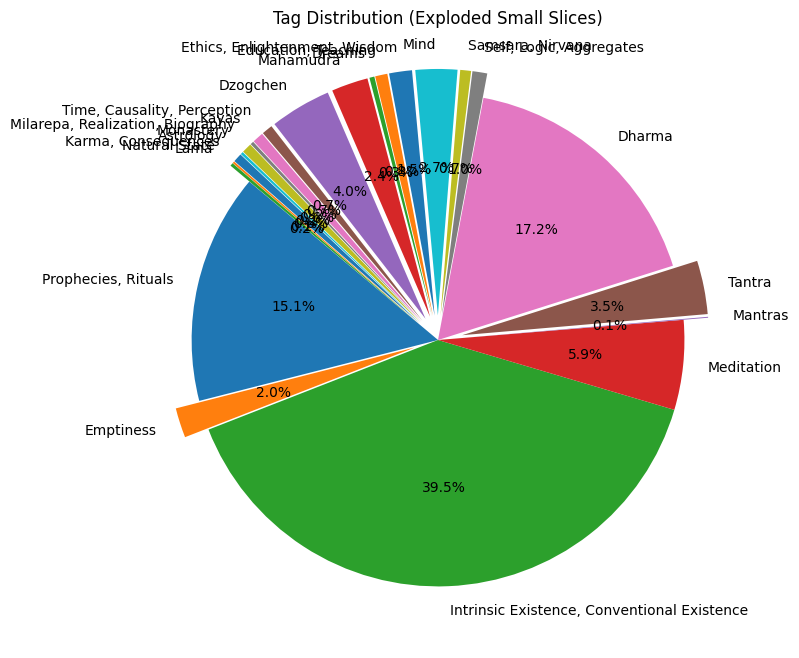

In [6]:
import matplotlib.pyplot as plt
from collections import Counter

# Extract the 'Tag' column and exclude empty strings
tags = [tag for tag in tagged_ds['Tag'] if tag != '']

total = len(tags)

# Count the occurrences of each tag
tag_counts = Counter(tags)

# Prepare data for the pie chart
labels = list(tag_counts.keys())
sizes = list(tag_counts.values())

threshold = 5

# Calculate the explode values
explode = [0.1 if (count / total * 100) < threshold else 0 for count in tag_counts.values()]

# Create the pie chart with explode
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, explode=explode)
plt.title('Tag Distribution (Exploded Small Slices)')
plt.show()



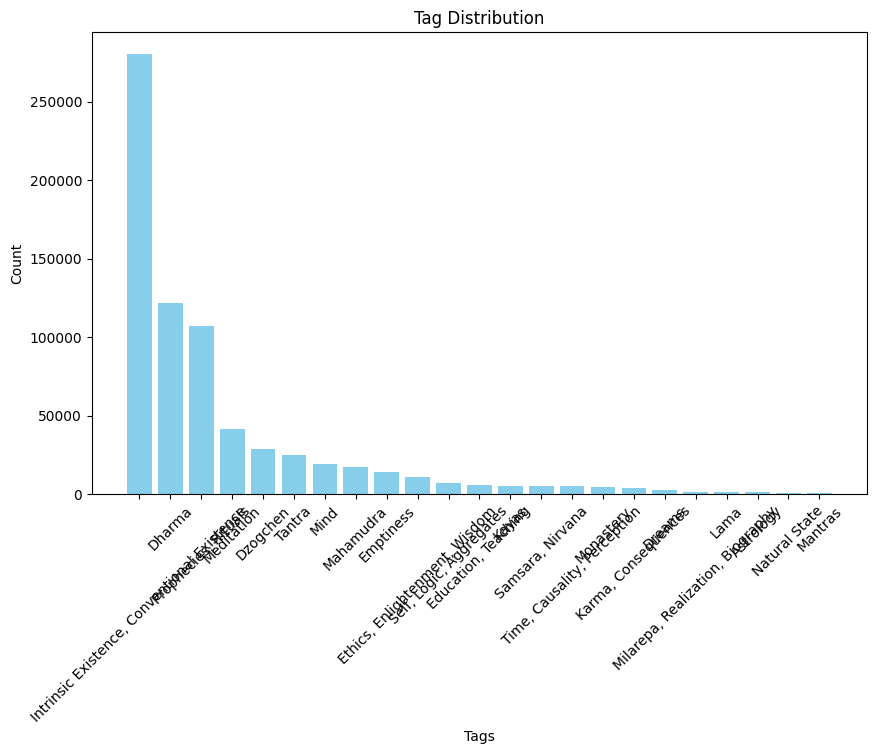

In [9]:
import matplotlib.pyplot as plt

# Sort the tags by count for better visualization
sorted_tags = sorted(tag_counts.items(), key=lambda x: x[1], reverse=True)
tags, counts = zip(*sorted_tags)

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(tags, counts, color='skyblue')
plt.xlabel('Tags')
plt.ylabel('Count')
plt.title('Tag Distribution')
plt.xticks(rotation=45)
plt.show()


In [31]:
import pandas as pd

# Create a DataFrame for the data
df = pd.DataFrame({'Tag': labels, 'Count': sizes, '%': [round(sizes[_]/total*100,2) for _ in range(len(sizes))]})
df


Tag   Count      %
0                           Prophecies, Rituals  107031  15.08
1                                     Emptiness   13849   1.95
2   Intrinsic Existence, Conventional Existence  280269  39.50
3                                    Meditation   41725   5.88
4                                       Mantras     430   0.06
5                                        Tantra   24904   3.51
6                                        Dharma  121826  17.17
7                       Self, Logic, Aggregates    6877   0.97
8                              Samsara, Nirvana    5041   0.71
9                                          Mind   19422   2.74
10                Ethics, Enlightenment, Wisdom   10616   1.50
11                          Education, Teaching    5693   0.80
12                                       Dreams    2303   0.32
13                                    Mahamudra   17057   2.40
14                                     Dzogchen   28467   4.01
15                  Time, Causality, Perception    5024   0.71
16                                        Kayas    5162   0.73
17             Milarepa, Realization, Biography    1522   0.21
18                                    Monastery    4610   0.65
19                                    Astrology    1225   0.17
20                          Karma, Consequences    4102   0.58
21                                Natural State     921   0.13
22                                         Lama    1455   0.21

In [18]:
empty_tag = [tag for tag in tagged_ds['Tag'] if tag == '']

In [28]:
len(ds) - len(empty_tag) 

709531

In [27]:
tagged_ds[10009]

{'Source': 'མཐར་ཚང་མས་རྒྱ་གར་གྱི་སྟོན་པ་ཉམ་ཆུང་རྣམས་བསད་པ་རེད། བསམ་བཞིན་གནས།',
 'Target': 'After all, every one of them was thinking, "Those poor Indian teachers had been killed!"',
 'File_Name': 'TM0345',
 'Machine Aligned': True,
 '__index_level_0__': 10050,
 'Tag': ''}